<a href="https://colab.research.google.com/github/KANG-dg/porject/blob/main/%EC%86%90%EA%B8%80%EC%94%A8_%EC%88%AB%EC%9E%90%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 모듈 불러오기
import torch  # torch
import torch.nn as nn  # 딥러닝 네트워크 구성요소 torch.nn
import torch.nn.functional as F #딥러닝 함수 포함 모듈 torch.nn.functional
import torch.optim as optim #가중치 추적에 필요한 최적화 알고리즘 torch.optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# 분석환경 설정
is_cuda=torch.cuda.is_available()
device=torch.device('cuda'if is_cuda else 'gpu')
# 가중치 업데이트 연산에서 어떤 장비 선택할지 
# gpu사용 가능하면 torch.cuda.is_available()에 true가 아니면 false저장됨

In [ ]:
# hyperparameter 지정
batch_size=50  # 모델 가중치 한번 업데이트 시 사용되는 샘플 단위 개수
epoch_num=15  # 학습데이터 모두 사용하여 학습하는 단위 횟수
learning_rate=0.0001 # 가중치 업데이트 정보

In [ ]:
#mnist 데이터 불러오기
train_data=datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data=datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
# root=데이터를 저장할 물리적 공간 위치 './data' 는 현재 폴더 의미
# train= 데이터를 학습용으로 사용 할 것인지 True/False
# download= True입력시 root에서 지정한 위치에 데이터 저장 이미 저장된 데이터 있을 시 False 입력
# transform=MNIST 데이터를 저장과 동시에 전처리 할 수 있는 옵션 
# pytorch 에서는 입력 데이터로 tensor를 사용하므로 이미지를 tensor로 변형하는 전처리 transforms.ToTensor() 사용
print('number of train data', len(train_data))
print('number of test data', len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

number of train data 60000
number of test data 10000


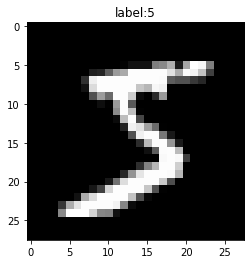

In [ ]:
image, label=train_data[0]  #학습 데이터의 입력과 정답 저장

plt.imshow(image.squeeze().numpy(), cmap='gray') # squeeze()함수는 크기가 1인 차원을 없앰 MNIST는 [1,28,28]3차원 텐서 2차원[28,28]로 축소
plt.title('label:%s'%label) 
plt.show()

In [ ]:
# 미니 배치 구성하기
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# torch.utils.data.DataLoader 는 손쉬운 배치구성과 학습과정 반복할 때 마다 미니 배치를 하나씩 불러오는 함수
# datasets: 미니배치로 구성할 데이터 / batch_size=미니 배치의 사이즈 /
# shuffle=데이터의 순서를 랜덤으로 섞어 미니 배치를 구성할지 여부 시계열 데이터가 아닐시 딥러닝이 데이터 순서를 학습하지 못하게 섞어줘야함

# 에폭(epoch): 하나의 단위. 1에폭은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당함.
# 미니 배치(mini batch): 전체 데이터 셋을 몇 개의 데이터 셋으로 나누었을 때, 그 작은 데이터 셋 뭉치
# 배치 사이즈(batch size): 하나의 미니 배치에 넘겨주는 데이터 갯수, 즉 한번의 배치마다 주는 샘플의 size
# 이터레이션(iteration): 하나의 미니 배치를 학습할 때 1iteration이라고 한다. 즉, 미니 배치 갯수 = 이터레이션 수

first_batch=train_loader.__iter__().__next__()  #iter(객체) 를 통해 값을 가져오고 next를 통해 다음요소를 가져옴 for문을 수동으로 실행하는것과 유사
print('{:15s}|{:<25s}|{}'.format('name','type','size'))
print('{:15s}|{:<25s}|{}'.format('Num od Batch','',len(train_loader)))
print('{:15s}|{:<25s}|{}'.format('first batch', str(type(first_batch)),len(first_batch)))
print('{:15s}|{:<25s}|{}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:15s}|{:<25s}|{}'.format('first_batch[1]',str(type(first_batch[1])),first_batch[1].shape))

# 60,000 개의 학습데이터에서 50의 배치사이즈를 사용했기에 1,200개의 미니배치 생성됨
# 미니배치의 첫번째 요소 first_batch[0] 는 [50,1,28,28]형태 4차원 tensor 각 요소는[batch_size,channel,width,height]
# 미니배치의 두번째 요소 first_batch[1]는 50크기 벡터 즉, 미니배치의 정답이 저장됨

name           |type                     |size
Num od Batch   |                         |1200
first batch    |<class 'list'>           |2
first_batch[0] |<class 'torch.Tensor'>   |torch.Size([50, 1, 28, 28])
first_batch[1] |<class 'torch.Tensor'>   |torch.Size([50])


In [ ]:
# 모델 학습
# 모델 생성 시 __init__를 통해 모델에 사용되는 가중치 형태 정의
# layer 쌓으면서 이전layer의 출력크기와 직후 layer의 입력 크기를 같게 설계해야 함
# feature map 공식= I(입력크기)+2p(padding크기)-F(filter size)+1/S(stride 크기)
# nn.Conv2d 함수는 padding=0, stride=1을 기본 값으로 사용
# maxpooling의 경우 tensor의 가로 세로에만 영향을 주므로 [64,24,24]에서 [64,12,12]로 반감
# flatten연산은 fully-connected layer연산을 위해 고차원 tensor를 1차원으로 줄임
# 3차원 tensor[64,12,12]를 9,216길이의 1차원 벡터로 변환
# 마지막 fully_connected layer인 fc2에서는 각 출력 클래스의 분류 확률을 받기 위해
# 크기를 맞추어야 함 MNIST는 0에서9까지 10개의 클래스이기에 10의 길이로 구성

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1=nn.Conv2d(1,32,3,1)
    # 첫번째 convolutional layer 각 옵션은(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    # in_channels는 conv1의 입력 tensor의 채널 크기 out_channels는 conv1의 출력 tensor크기 out_channels는 conv2의 in_channels와 같아야함
    # kernel_size는 filter의 크기를 나타내며 scalar 값으로 나타낼 경우 가로와 세로 크기가 같은 2D filter생성 kernem_size=3은 (3x3)filter
    # stride는 filter가 움직이는 단위 padding은 지정하지 않았으므로 0으로 적용되어 실행되지 않음 
    self.conv2=nn.Conv2d(32,64,3,1)
    self.dropout1=nn.Dropout2d(0.25) # 확률0.25의 dropout
    self.dropout2=nn.Dropout2d(0.5) # 확률 0.5의 dropout
    self.fc1=nn.Linear(9216,128)
    # 첫 번쨰 fully_connected layer fc1정의 9216크기의 벡터를 128크기로 변환하는 가중치 설계
    self.fc2=nn.Linear(128,10)
    # 두 번째 fully connected layer fc2정의 fc1의 128크기 벡터를 mnist클래스 개수인 10크기의 벡터로 변환하는 가중치 설계

  def forward(self,x):  # 입력 이미지와 정의한 가중치를 이용해 feed forward연산을 정의  
    x=self.conv1(x)   # 입력 이미지를 conv1레이어에 통과
    x=F.relu(x)   # ReLu활성함수 적용 활성함수는 단순 연산이므로 __init__에서 정의한 학습 가중치 없음
    x=self.conv2(x) # conv2레이어 통과
    x=F.relu(x) #ReLu 활성함수 적용
    x=F.max_pool2d(x,2) #(2x2)크기의 filter로 max pooling을 적용 pooling layer는 단순 연산이므로 학습 가중치 없음
    x=self.dropout1(x)  #사전에 정의한 0.25의 확률의 dropout1을 반영
    x=torch.flatten(x,1)   # torch.flatten함수를 통해 fully_connected layer를 통과하기 전 고차원의 tensor를 1차원 벡터로 변경
                             # 2개의 convolutional layer와 1번의 maxpooling으로 만들어 진 [64,12,12]크기의 3차원 tensor를 9,216크기 벡터로 변환
    x=self.fc1(x)   # 9,216크기 벡터를 128크기 벡터로 학습하는 fc1을 통과
    x=F.relu(x)  # ReLu활성함수 적용
    x=self.dropout2(x) # 기존에 정의한 0.5확률의 dropout2를 반영
    x=self.fc2(x)  # 두 번째 fully_connected layer인 fc2를 통과하면서 벡터 사이즈 128에서 10으로 줄임
    output=F.log_softmax(x,dim=1) # 최종 출력값으로 log_softmax를 계산 softmax함수가 아닌 lof_softmax() 사용시 연산속도 높일 수 있음
    return output  # 최종 출력값 반환

In [ ]:
model=CNN().to(device) # CNN클래스를 이용 model이라는 인스턴스 생성 이 때 코드 상단에 지정한 연산장비(cpu/gpu)device를 인식
optimizer=optim.Adam(model.parameters(), lr=learning_rate) # 손실함수를 최소로하는 가중치를 찾기 위해 Adam알고리즘의 optimizer를 지정
criterion=nn.CrossEntropyLoss() # MNIST는 다중 클래스 분류 문제이기에 교차 엔트로피(cross entropy)를 손실함수로 설정

In [ ]:
# 설계한 cnn모형 확인
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# 모델 학습
model.train() # cnn클래스 저장돈 model인스턴스를 학습모드로 실행
i=0  #반복 학습중 손실 함수 현황을 확인하고자 학습 횟수를 나타내는 보조 인덱스 지정
for epoch in range(epoch_num): # 미리 저장해둔 epoch수 만큼 반복학습 for문 선언
  for data, target in train_loader: # 학습 데이터를 batch_size로 나눈 만큼 반복 수행하며 train_loader는 매 시행마다 미니배치의 데이터와 정답을 data와 target에 저장
    data=data.to(device)  # 미니배치의 데이터를 기존에 지정한 장비 device에 할당
    target=target.to(device) # 미니배치의 정답을 기존에 지정한 장비 device에 할당
    optimizer.zero_grad() # 학습 시작 전 이전 반복시행에서 저장된 optimizer의 gradient를 초기화
    output=model(data) # 미니 배치 데이터를 모델에 통과시키는 feed forward연산으로 결괏값 계산
    loss=criterion(output, target) # 계산된 결괏괎과 실제 정답으로 손실 함수를 계산
    loss.backward() # 손실함수로 gradient를 계산
    optimizer.step() # 위에서 계산된 gradient를 통해 모델의 가중치 업데이트
    if i % 1000==0:  # 학습이 잘 되는지 확인하기위해 1000번째 마가 손실함수 확인하기위한 if문
      print('train step:{}\tLoss:{:.3f}'.format(i,loss.item())) # 손실함수 출력
    i+=1 # 학습완료시 보조인덱스 +1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train step:0	Loss:2.303
train step:1000	Loss:0.183
train step:2000	Loss:0.224
train step:3000	Loss:0.267
train step:4000	Loss:0.291
train step:5000	Loss:0.031
train step:6000	Loss:0.110
train step:7000	Loss:0.051
train step:8000	Loss:0.183
train step:9000	Loss:0.101
train step:10000	Loss:0.105
train step:11000	Loss:0.150
train step:12000	Loss:0.164
train step:13000	Loss:0.091
train step:14000	Loss:0.150
train step:15000	Loss:0.020
train step:16000	Loss:0.060
train step:17000	Loss:0.193


In [ ]:
model.eval() # eval함수 호출하여 dropoup적용되지 않고 batch_nomalization도 평가모드로 전화
correct=0 # 정답 개수 저장할 correct 초기화
for data, target in test_loader: # 테스트 데이터를 batch_size로 나눈만큼 반복 수햏되면 test_loader는 시행마다 미니 배치의 데이터와 정답을 data와 target에 저장
  data=data.to(device) # 미니배치의 데이터를 기존에 지정한 장비 device에 할당
  target=target.to(device) # 미디배치의 정답을 기존에 지정한 장비 device에 할당
  output=model(data) # 미니 배치 데이터를 모델에 통과시켜 결괏값 계산
  prediction=output.data.max(1)[1] # log_softmax 값이 가장 큰 인덱스를 예측값으로 저장
  correct+=prediction.eq(target.data).sum() # 실제 정답과 예측값이 같으면 True 아니면 False인 논리값으로 구성된 백터를 더함
                                            # 미니 배치 중 정답의 개수를 구하고 반복 시행마다 누적하여 더함  .eq는 (=) 과 같은 의미

print('Test set: Accuracy:{:.2f}'.format(100*correct/len(test_loader.dataset))) # 전체 테스트 데이터 중 맞춘 개수의 비율을 통해 정확도 뎨산하여 출력

Test set: Accuracy:99.00
